Multi-Driver Grand Prix Telemetry Analysis

This notebook engineers telemetry data from the Fast-F1 API for telemetry dataframes for multiple drivers. It utilizes a structured workflow for data acquisition, preparation, and further exploration prior to applying machine learning models to multi-driver behavior analysis results. Additional descriptive statistics are added to single driver data frames that will then be concatenated and used as input for machine learning models.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.ERROR)

In this section, I import Python libraries for data visualization, numerical analysis, and working with the Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

These session parameters were chosen to best match Tier 2 controls:

- Location: Bahrain (clear, windy conditions)
- Green Flag Laps: Remove safety car and VSC distortions
- Single-compound Windows: Avoid mixed group comparisons
- Minimize Outliers: Tire age approx. 20 laps
- Traffic: Avoid slipstream bias (lead >2s ahead)
- Corner Analysis → Isolates driver techniques

In [3]:
year = 2025
grand_prix = f1_constants.F1Constants.LOCATIONS["Bahrain"]
session_type = f1_constants.F1Constants.SESSIONS["R"]

safety_car_laps = [32, 33, 34, 35]

session = f1_data.F1Session(year, grand_prix, session_type)

req         WARNING 	DEFAULT CACHE ENABLED! (1.03 GB) /Users/phillipsmith/Library/Caches/fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '1

All drivers who participated in the specific location's Grand Prix will be analyzed and assigned variables to be identified by their three-letter name code.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

Sector timestamps variables are set for easy replacment during telemetry filtering.

In [4]:
# driver constants
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
hamilton = f1_constants.F1Constants.DRIVERS["Lewis Hamilton"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
ocon = f1_constants.F1Constants.DRIVERS["Esteban Ocon"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
bearman = f1_constants.F1Constants.DRIVERS["Oliver Bearman"]
antonelli = f1_constants.F1Constants.DRIVERS["Andrea Kimi Antonelli"]
albon = f1_constants.F1Constants.DRIVERS["Alexander Albon"]
hadjar = f1_constants.F1Constants.DRIVERS["Isack Hadjar"]
doohan = f1_constants.F1Constants.DRIVERS["Jack Doohan"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
bortoleto = f1_constants.F1Constants.DRIVERS["Gabriel Bortoleto"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]
# steering = f1_constants.F1Constants.TELEMETRY_COLUMNS["Steering Wheel Angle (°)"]

# sector timestamp variables
s1_start = 'Sector1Start'
s1_end_s2_start = 'Sector1End_Sector2Start'
s2_end_s3_start = 'Sector2End_Sector3Start'
s3_end = 'Sector3End'

The code below retrieves circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

critical_turn = [10]
radius = 2500

Gather, clean, and enrich each drivers' list of telemetry dataframes for their valid laps.

Each telemetry dataframe is filtered by turn to focus on the most informative segments for analyzing driver behavior and technique at brake-intensive areas.

Lando Norris Race Telemetry & Performance Metrics

In [6]:
norris_laps = session.laps.pick_drivers(norris)
norris_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(norris_laps, safety_car_laps)
norris_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(norris_laps_filtered)
norris_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(norris_laps_filtered)

# clean each telemetry dataframes for valid laps
norris_telemetry_lap_cleaned_list = []
for norris_telemetry_lap in norris_telemetry:
    norris_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(norris_telemetry_lap, norris)
    norris_telemetry_lap_cleaned_list.append(norris_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for norris_telemetry_lap_cleaned in norris_telemetry_lap_cleaned_list:
    if norris_telemetry_lap_cleaned['LapNumber'].iloc[0] in norris_sector_timestamps_dict.keys():
        lap_number = norris_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = norris_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = norris_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        norris_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
norris_performance_metrics_df = pd.DataFrame(performance_metrics_list)

norris_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=norris,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
norris_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
norris_final_feature_df = pd.concat([norris_eda_summary_df, norris_performance_metrics_df.reset_index(drop=True)], axis=1)

Lando Norris Fastest Lap Telemetry for Visualization

In [7]:
# get fastest corner lap telemetry dataframe
norris_fastest_lap_idx = norris_laps_filtered.loc[norris_laps_filtered['LapTime'].idxmin()]
norris_fastest_telemetry = norris_fastest_lap_idx.get_telemetry()

# get the fastest lap number
fastest_lap_number = norris_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
norris_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    norris_fastest_telemetry,
    norris
)

# filter the cleaned telemetry down to the sector timeframe
sector_start = norris_sector_timestamps_dict[fastest_lap_number][s1_end_s2_start]
sector_end = norris_sector_timestamps_dict[fastest_lap_number][s2_end_s3_start]

norris_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    norris_fastest_telemetry_cleaned,
    start=sector_start,
    end=sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
norris_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    norris_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
norris_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(norris_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Oscar Piastri Race Telemetry & Performance Metrics

In [8]:
piastri_laps = session.laps.pick_drivers(piastri)
piastri_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(piastri_laps, safety_car_laps)
piastri_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(piastri_laps_filtered)
piastri_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(piastri_laps_filtered)

# clean each telemetry dataframes for valid laps
piastri_telemetry_lap_cleaned_list = []
for piastri_telemetry_lap in piastri_telemetry:
    piastri_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(piastri_telemetry_lap, piastri)
    piastri_telemetry_lap_cleaned_list.append(piastri_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for piastri_telemetry_lap_cleaned in piastri_telemetry_lap_cleaned_list:
    if piastri_telemetry_lap_cleaned['LapNumber'].iloc[0] in piastri_sector_timestamps_dict.keys():
        lap_number = piastri_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = piastri_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = piastri_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        piastri_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
piastri_performance_metrics_df = pd.DataFrame(performance_metrics_list)

piastri_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=piastri,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
piastri_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
piastri_final_feature_df = pd.concat([piastri_eda_summary_df, piastri_performance_metrics_df.reset_index(drop=True)], axis=1)

Oscar Piastri Fastest Lap Telemetry for Visualization

In [9]:
# get fastest corner lap telemetry dataframe
piastri_fastest_lap_idx = piastri_laps_filtered.loc[piastri_laps_filtered['LapTime'].idxmin()]
piastri_fastest_telemetry = piastri_fastest_lap_idx.get_telemetry()

# get the fastest lap number
fastest_lap_number = piastri_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
piastri_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    piastri_fastest_telemetry,
    piastri
)

# filter the cleaned telemetry down to the sector timeframe
sector_start = piastri_sector_timestamps_dict[fastest_lap_number][s1_end_s2_start]
sector_end = piastri_sector_timestamps_dict[fastest_lap_number][s2_end_s3_start]

piastri_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    piastri_fastest_telemetry_cleaned,
    start=sector_start,
    end=sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
piastri_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    piastri_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
piastri_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(piastri_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

George Russell Race Telemetry & Performance Metrics

In [10]:
russell_laps = session.laps.pick_drivers(russell)
russell_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(russell_laps, safety_car_laps)
russell_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(russell_laps_filtered)
russell_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(russell_laps_filtered)

# clean each telemetry dataframes for valid laps
russell_telemetry_lap_cleaned_list = []
for russell_telemetry_lap in russell_telemetry:
    russell_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(russell_telemetry_lap, russell)
    russell_telemetry_lap_cleaned_list.append(russell_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for russell_telemetry_lap_cleaned in russell_telemetry_lap_cleaned_list:
    if russell_telemetry_lap_cleaned['LapNumber'].iloc[0] in russell_sector_timestamps_dict.keys():
        lap_number = russell_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = russell_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = russell_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        russell_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
russell_performance_metrics_df = pd.DataFrame(performance_metrics_list)

russell_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=russell,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
russell_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
russell_final_feature_df = pd.concat([russell_eda_summary_df, russell_performance_metrics_df.reset_index(drop=True)], axis=1)

George Russell Fastest Lap Telemetry for Visualization

In [11]:
# get fastest corner lap telemetry dataframe
russell_fastest_lap_idx = russell_laps_filtered.loc[russell_laps_filtered['LapTime'].idxmin()]
russell_fastest_telemetry = russell_fastest_lap_idx.get_telemetry()

# get the fastest lap number
fastest_lap_number = russell_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
russell_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    russell_fastest_telemetry,
    russell
)

# filter the cleaned telemetry down to the sector timeframe
sector_start = russell_sector_timestamps_dict[fastest_lap_number][s1_end_s2_start]
sector_end = russell_sector_timestamps_dict[fastest_lap_number][s2_end_s3_start]

russell_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    russell_fastest_telemetry_cleaned,
    start=sector_start,
    end=sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
russell_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    russell_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
russell_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(russell_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Charles Leclerc Race Telemetry & Performance Metrics

In [12]:
leclerc_laps = session.laps.pick_drivers(leclerc)
leclerc_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(leclerc_laps, safety_car_laps)
leclerc_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(leclerc_laps_filtered)
leclerc_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(leclerc_laps_filtered)

# clean each telemetry dataframes for valid laps
leclerc_telemetry_lap_cleaned_list = []
for leclerc_telemetry_lap in leclerc_telemetry:
    leclerc_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(leclerc_telemetry_lap, leclerc)
    leclerc_telemetry_lap_cleaned_list.append(leclerc_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for leclerc_telemetry_lap_cleaned in leclerc_telemetry_lap_cleaned_list:
    if leclerc_telemetry_lap_cleaned['LapNumber'].iloc[0] in leclerc_sector_timestamps_dict.keys():
        lap_number = leclerc_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = leclerc_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = leclerc_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        leclerc_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
leclerc_performance_metrics_df = pd.DataFrame(performance_metrics_list)

leclerc_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=leclerc,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
leclerc_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
leclerc_final_feature_df = pd.concat([leclerc_eda_summary_df, leclerc_performance_metrics_df.reset_index(drop=True)], axis=1)

Charles Leclerc Fastest Lap Telemetry for Visualization

In [13]:
# get fastest corner lap telemetry dataframe
leclerc_fastest_lap_idx = leclerc_laps_filtered.loc[leclerc_laps_filtered['LapTime'].idxmin()]
leclerc_fastest_telemetry = leclerc_fastest_lap_idx.get_telemetry()

# get the fastest lap number
fastest_lap_number = leclerc_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
leclerc_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    leclerc_fastest_telemetry,
    leclerc
)

# filter the cleaned telemetry down to the sector timeframe
sector_start = leclerc_sector_timestamps_dict[fastest_lap_number][s1_end_s2_start]
sector_end = leclerc_sector_timestamps_dict[fastest_lap_number][s2_end_s3_start]

leclerc_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    leclerc_fastest_telemetry_cleaned,
    start=sector_start,
    end=sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
leclerc_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    leclerc_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
leclerc_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(leclerc_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Lewis Hamilton Race Telemetry & Performance Metrics

In [14]:
hamilton_laps = session.laps.pick_drivers(hamilton)
hamilton_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(hamilton_laps, safety_car_laps)
hamilton_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(hamilton_laps_filtered)
hamilton_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(hamilton_laps_filtered)

# clean each telemetry dataframes for valid laps
hamilton_telemetry_lap_cleaned_list = []
for hamilton_telemetry_lap in hamilton_telemetry:
    hamilton_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(hamilton_telemetry_lap, hamilton)
    hamilton_telemetry_lap_cleaned_list.append(hamilton_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for hamilton_telemetry_lap_cleaned in hamilton_telemetry_lap_cleaned_list:
    if hamilton_telemetry_lap_cleaned['LapNumber'].iloc[0] in hamilton_sector_timestamps_dict.keys():
        lap_number = hamilton_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = hamilton_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = hamilton_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        hamilton_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
hamilton_performance_metrics_df = pd.DataFrame(performance_metrics_list)

hamilton_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=hamilton,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
hamilton_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
hamilton_final_feature_df = pd.concat([hamilton_eda_summary_df, hamilton_performance_metrics_df.reset_index(drop=True)], axis=1)

Lewis Hamilton Fastest Lap Telemetry for Visualization

In [15]:
# get fastest corner lap telemetry dataframe
hamilton_fastest_lap_idx = hamilton_laps_filtered.loc[hamilton_laps_filtered['LapTime'].idxmin()]
hamilton_fastest_telemetry = hamilton_fastest_lap_idx.get_telemetry()

# get the fastest lap number
fastest_lap_number = hamilton_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
hamilton_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    hamilton_fastest_telemetry,
    hamilton
)

# filter the cleaned telemetry down to the sector timeframe
sector_start = hamilton_sector_timestamps_dict[fastest_lap_number][s1_end_s2_start]
sector_end = hamilton_sector_timestamps_dict[fastest_lap_number][s2_end_s3_start]

hamilton_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    hamilton_fastest_telemetry_cleaned,
    start=sector_start,
    end=sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
hamilton_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    hamilton_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
hamilton_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(hamilton_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Max Verstappen Race Telemetry & Performance Metrics

In [16]:
verstappen_laps = session.laps.pick_drivers(verstappen)
verstappen_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(verstappen_laps, safety_car_laps)
verstappen_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(verstappen_laps_filtered)
verstappen_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(verstappen_laps_filtered)

# clean each telemetry dataframes for valid laps
verstappen_telemetry_lap_cleaned_list = []
for verstappen_telemetry_lap in verstappen_telemetry:
    verstappen_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(verstappen_telemetry_lap, verstappen)
    verstappen_telemetry_lap_cleaned_list.append(verstappen_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for verstappen_telemetry_lap_cleaned in verstappen_telemetry_lap_cleaned_list:
    if verstappen_telemetry_lap_cleaned['LapNumber'].iloc[0] in verstappen_sector_timestamps_dict.keys():
        lap_number = verstappen_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = verstappen_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = verstappen_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        verstappen_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
verstappen_performance_metrics_df = pd.DataFrame(performance_metrics_list)

verstappen_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=verstappen,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
verstappen_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
verstappen_final_feature_df = pd.concat([verstappen_eda_summary_df, verstappen_performance_metrics_df.reset_index(drop=True)], axis=1)

Max Verstappen Fastest Lap Telemetry for Visualization

In [17]:
# get fastest corner lap telemetry dataframe
verstappen_fastest_lap_idx = verstappen_laps_filtered.loc[verstappen_laps_filtered['LapTime'].idxmin()]
verstappen_fastest_telemetry = verstappen_fastest_lap_idx.get_telemetry()

# get the fastest lap number
fastest_lap_number = verstappen_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
verstappen_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    verstappen_fastest_telemetry,
    verstappen
)

# filter the cleaned telemetry down to the sector timeframe
sector_start = verstappen_sector_timestamps_dict[fastest_lap_number][s1_end_s2_start]
sector_end = verstappen_sector_timestamps_dict[fastest_lap_number][s2_end_s3_start]

verstappen_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    verstappen_fastest_telemetry_cleaned,
    start=sector_start,
    end=sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
verstappen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    verstappen_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
verstappen_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(verstappen_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Pierre Gasly Race Telemetry & Performance Metrics

In [18]:
gasly_laps = session.laps.pick_drivers(gasly)
gasly_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(gasly_laps, safety_car_laps)
gasly_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(gasly_laps_filtered)
gasly_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(gasly_laps_filtered)

# clean each telemetry dataframes for valid laps
gasly_telemetry_lap_cleaned_list = []
for gasly_telemetry_lap in gasly_telemetry:
    gasly_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(gasly_telemetry_lap, gasly)
    gasly_telemetry_lap_cleaned_list.append(gasly_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for gasly_telemetry_lap_cleaned in gasly_telemetry_lap_cleaned_list:
    if gasly_telemetry_lap_cleaned['LapNumber'].iloc[0] in gasly_sector_timestamps_dict.keys():
        lap_number = gasly_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = gasly_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = gasly_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        gasly_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

corner_telemetry_enriched_list[0]

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
gasly_performance_metrics_df = pd.DataFrame(performance_metrics_list)

gasly_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=gasly,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
gasly_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
gasly_final_feature_df = pd.concat([gasly_eda_summary_df, gasly_performance_metrics_df.reset_index(drop=True)], axis=1)

Pierre Gasly Fastest Lap Telemetry for Visualization

In [19]:
# get fastest corner lap telemetry dataframe for Gasly
gasly_fastest_lap_idx = gasly_laps_filtered.loc[gasly_laps_filtered['LapTime'].idxmin()]
gasly_fastest_telemetry = gasly_fastest_lap_idx.get_telemetry()

# get Gasly's fastest lap number
gasly_fastest_lap_number = gasly_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
gasly_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    gasly_fastest_telemetry,
    gasly
)

# filter the cleaned telemetry down to the sector timeframe
gasly_sector_start = gasly_sector_timestamps_dict[gasly_fastest_lap_number][s1_end_s2_start]
gasly_sector_end = gasly_sector_timestamps_dict[gasly_fastest_lap_number][s2_end_s3_start]

gasly_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    gasly_fastest_telemetry_cleaned,
    start=gasly_sector_start,
    end=gasly_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
gasly_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    gasly_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
gasly_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(gasly_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)


Esteban Ocon Race Telemetry & Performance Metrics

In [20]:
ocon_laps = session.laps.pick_drivers(ocon)
ocon_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(ocon_laps, safety_car_laps)
ocon_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(ocon_laps_filtered)
ocon_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(ocon_laps_filtered)

# clean each telemetry dataframes for valid laps
ocon_telemetry_lap_cleaned_list = []
for ocon_telemetry_lap in ocon_telemetry:
    ocon_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(ocon_telemetry_lap, ocon)
    ocon_telemetry_lap_cleaned_list.append(ocon_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for ocon_telemetry_lap_cleaned in ocon_telemetry_lap_cleaned_list:
    if ocon_telemetry_lap_cleaned['LapNumber'].iloc[0] in ocon_sector_timestamps_dict.keys():
        lap_number = ocon_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = ocon_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = ocon_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        ocon_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
ocon_performance_metrics_df = pd.DataFrame(performance_metrics_list)

ocon_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=ocon,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
ocon_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
ocon_final_feature_df = pd.concat([ocon_eda_summary_df, ocon_performance_metrics_df.reset_index(drop=True)], axis=1)

Esteban Ocon Fastest Lap Telemetry for Visualization

In [21]:
# get fastest corner lap telemetry dataframe for Ocon
ocon_fastest_lap_idx = ocon_laps_filtered.loc[ocon_laps_filtered['LapTime'].idxmin()]
ocon_fastest_telemetry = ocon_fastest_lap_idx.get_telemetry()

# get Ocon's fastest lap number
ocon_fastest_lap_number = ocon_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
ocon_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    ocon_fastest_telemetry,
    ocon
)

# filter the cleaned telemetry down to the sector timeframe
ocon_sector_start = ocon_sector_timestamps_dict[ocon_fastest_lap_number][s1_end_s2_start]
ocon_sector_end = ocon_sector_timestamps_dict[ocon_fastest_lap_number][s2_end_s3_start]

ocon_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    ocon_fastest_telemetry_cleaned,
    start=ocon_sector_start,
    end=ocon_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
ocon_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    ocon_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
ocon_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(ocon_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Yuki Tsunoda Race Telemetry & Performance Metrics

In [22]:
tsunoda_laps = session.laps.pick_drivers(tsunoda)
tsunoda_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(tsunoda_laps, safety_car_laps)
tsunoda_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(tsunoda_laps_filtered)
tsunoda_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(tsunoda_laps_filtered)

# clean each telemetry dataframes for valid laps
tsunoda_telemetry_lap_cleaned_list = []
for tsunoda_telemetry_lap in tsunoda_telemetry:
    tsunoda_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(tsunoda_telemetry_lap, tsunoda)
    tsunoda_telemetry_lap_cleaned_list.append(tsunoda_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for tsunoda_telemetry_lap_cleaned in tsunoda_telemetry_lap_cleaned_list:
    if tsunoda_telemetry_lap_cleaned['LapNumber'].iloc[0] in tsunoda_sector_timestamps_dict.keys():
        lap_number = tsunoda_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = tsunoda_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = tsunoda_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        tsunoda_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
tsunoda_performance_metrics_df = pd.DataFrame(performance_metrics_list)

tsunoda_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=tsunoda,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
tsunoda_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
tsunoda_final_feature_df = pd.concat([tsunoda_eda_summary_df, tsunoda_performance_metrics_df.reset_index(drop=True)], axis=1)

Yuki Tsunoda Fastest Lap Telemetry for Visualization

In [23]:
# get fastest corner lap telemetry dataframe for Tsunoda
tsunoda_fastest_lap_idx = tsunoda_laps_filtered.loc[tsunoda_laps_filtered['LapTime'].idxmin()]
tsunoda_fastest_telemetry = tsunoda_fastest_lap_idx.get_telemetry()

# get Tsunoda's fastest lap number
tsunoda_fastest_lap_number = tsunoda_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
tsunoda_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    tsunoda_fastest_telemetry,
    tsunoda
)

# filter the cleaned telemetry down to the sector timeframe
tsunoda_sector_start = tsunoda_sector_timestamps_dict[tsunoda_fastest_lap_number][s1_end_s2_start]
tsunoda_sector_end = tsunoda_sector_timestamps_dict[tsunoda_fastest_lap_number][s2_end_s3_start]

tsunoda_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    tsunoda_fastest_telemetry_cleaned,
    start=tsunoda_sector_start,
    end=tsunoda_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
tsunoda_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    tsunoda_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
tsunoda_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(tsunoda_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Oliver Bearman Race Telemetry & Performance Metrics

In [24]:
bearman_laps = session.laps.pick_drivers(bearman)
bearman_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(bearman_laps, safety_car_laps)
bearman_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(bearman_laps_filtered)
bearman_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(bearman_laps_filtered)

# clean each telemetry dataframes for valid laps
bearman_telemetry_lap_cleaned_list = []
for bearman_telemetry_lap in bearman_telemetry:
    bearman_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(bearman_telemetry_lap, bearman)
    bearman_telemetry_lap_cleaned_list.append(bearman_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for bearman_telemetry_lap_cleaned in bearman_telemetry_lap_cleaned_list:
    if bearman_telemetry_lap_cleaned['LapNumber'].iloc[0] in bearman_sector_timestamps_dict.keys():
        lap_number = bearman_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = bearman_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = bearman_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        bearman_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
bearman_performance_metrics_df = pd.DataFrame(performance_metrics_list)

bearman_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=bearman,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
bearman_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
bearman_final_feature_df = pd.concat([bearman_eda_summary_df, bearman_performance_metrics_df.reset_index(drop=True)], axis=1)

Oliver Bearman Fastest Lap Telemetry for Visualization

In [25]:
# get fastest corner lap telemetry dataframe for Bearman
bearman_fastest_lap_idx = bearman_laps_filtered.loc[bearman_laps_filtered['LapTime'].idxmin()]
bearman_fastest_telemetry = bearman_fastest_lap_idx.get_telemetry()

# get Bearman's fastest lap number
bearman_fastest_lap_number = bearman_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
bearman_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    bearman_fastest_telemetry,
    bearman
)

# filter the cleaned telemetry down to the sector timeframe
bearman_sector_start = bearman_sector_timestamps_dict[bearman_fastest_lap_number][s1_end_s2_start]
bearman_sector_end = bearman_sector_timestamps_dict[bearman_fastest_lap_number][s2_end_s3_start]

bearman_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    bearman_fastest_telemetry_cleaned,
    start=bearman_sector_start,
    end=bearman_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
bearman_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    bearman_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
bearman_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(bearman_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Andrea Kimi Antonelli Race Telemetry & Performance Metrics

In [26]:
antonelli_laps = session.laps.pick_drivers(antonelli)
antonelli_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(antonelli_laps, safety_car_laps)
antonelli_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(antonelli_laps_filtered)
antonelli_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(antonelli_laps_filtered)

# clean each telemetry dataframes for valid laps
antonelli_telemetry_lap_cleaned_list = []
for antonelli_telemetry_lap in antonelli_telemetry:
    antonelli_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(antonelli_telemetry_lap, antonelli)
    antonelli_telemetry_lap_cleaned_list.append(antonelli_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for antonelli_telemetry_lap_cleaned in antonelli_telemetry_lap_cleaned_list:
    if antonelli_telemetry_lap_cleaned['LapNumber'].iloc[0] in antonelli_sector_timestamps_dict.keys():
        lap_number = antonelli_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = antonelli_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = antonelli_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        antonelli_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
antonelli_performance_metrics_df = pd.DataFrame(performance_metrics_list)

antonelli_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=antonelli,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
antonelli_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
antonelli_final_feature_df = pd.concat([antonelli_eda_summary_df, antonelli_performance_metrics_df.reset_index(drop=True)], axis=1)

Andrea Kimi Antonelli Fastest Lap Telemetry for Visualization

In [27]:
# get fastest corner lap telemetry dataframe for Antonelli
antonelli_fastest_lap_idx = antonelli_laps_filtered.loc[antonelli_laps_filtered['LapTime'].idxmin()]
antonelli_fastest_telemetry = antonelli_fastest_lap_idx.get_telemetry()

# get Antonelli's fastest lap number
antonelli_fastest_lap_number = antonelli_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
antonelli_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    antonelli_fastest_telemetry,
    antonelli
)

# filter the cleaned telemetry down to the sector timeframe
antonelli_sector_start = antonelli_sector_timestamps_dict[antonelli_fastest_lap_number][s1_end_s2_start]
antonelli_sector_end = antonelli_sector_timestamps_dict[antonelli_fastest_lap_number][s2_end_s3_start]

antonelli_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    antonelli_fastest_telemetry_cleaned,
    start=antonelli_sector_start,
    end=antonelli_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
antonelli_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    antonelli_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
antonelli_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(antonelli_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Alexander Albon Race Telemetry & Performance Metrics

In [28]:
albon_laps = session.laps.pick_drivers(albon)
albon_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(albon_laps, safety_car_laps)
albon_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(albon_laps_filtered)
albon_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(albon_laps_filtered)

# clean each telemetry dataframes for valid laps
albon_telemetry_lap_cleaned_list = []
for albon_telemetry_lap in albon_telemetry:
    albon_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(albon_telemetry_lap, albon)
    albon_telemetry_lap_cleaned_list.append(albon_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for albon_telemetry_lap_cleaned in albon_telemetry_lap_cleaned_list:
    if albon_telemetry_lap_cleaned['LapNumber'].iloc[0] in albon_sector_timestamps_dict.keys():
        lap_number = albon_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = albon_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = albon_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        albon_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
albon_performance_metrics_df = pd.DataFrame(performance_metrics_list)

albon_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=albon,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
albon_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
albon_final_feature_df = pd.concat([albon_eda_summary_df, albon_performance_metrics_df.reset_index(drop=True)], axis=1)

Alexander Albon Fastest Lap Telemetry for Visualization

In [29]:
# get fastest corner lap telemetry dataframe for Albon
albon_fastest_lap_idx = albon_laps_filtered.loc[albon_laps_filtered['LapTime'].idxmin()]
albon_fastest_telemetry = albon_fastest_lap_idx.get_telemetry()

# get Albon's fastest lap number
albon_fastest_lap_number = albon_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
albon_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    albon_fastest_telemetry,
    albon
)

# filter the cleaned telemetry down to the sector timeframe
albon_sector_start = albon_sector_timestamps_dict[albon_fastest_lap_number][s1_end_s2_start]
albon_sector_end = albon_sector_timestamps_dict[albon_fastest_lap_number][s2_end_s3_start]

albon_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    albon_fastest_telemetry_cleaned,
    start=albon_sector_start,
    end=albon_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
albon_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    albon_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
albon_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(albon_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Isack Hadjar Race Telemetry & Performance Metrics

In [30]:
hadjar_laps = session.laps.pick_drivers(hadjar)
hadjar_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(hadjar_laps, safety_car_laps)
hadjar_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(hadjar_laps_filtered)
hadjar_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(hadjar_laps_filtered)

# clean each telemetry dataframes for valid laps
hadjar_telemetry_lap_cleaned_list = []
for hadjar_telemetry_lap in hadjar_telemetry:
    hadjar_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(hadjar_telemetry_lap, hadjar)
    hadjar_telemetry_lap_cleaned_list.append(hadjar_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for hadjar_telemetry_lap_cleaned in hadjar_telemetry_lap_cleaned_list:
    if hadjar_telemetry_lap_cleaned['LapNumber'].iloc[0] in hadjar_sector_timestamps_dict.keys():
        lap_number = hadjar_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = hadjar_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = hadjar_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        hadjar_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
hadjar_performance_metrics_df = pd.DataFrame(performance_metrics_list)

hadjar_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=hadjar,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
hadjar_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
hadjar_final_feature_df = pd.concat([hadjar_eda_summary_df, hadjar_performance_metrics_df.reset_index(drop=True)], axis=1)

Isack Hadjar Fastest Lap Telemetry for Visualization

In [31]:
# get fastest corner lap telemetry dataframe for Hadjar
hadjar_fastest_lap_idx = hadjar_laps_filtered.loc[hadjar_laps_filtered['LapTime'].idxmin()]
hadjar_fastest_telemetry = hadjar_fastest_lap_idx.get_telemetry()

# get Hadjar's fastest lap number
hadjar_fastest_lap_number = hadjar_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
hadjar_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    hadjar_fastest_telemetry,
    hadjar
)

# filter the cleaned telemetry down to the sector timeframe
hadjar_sector_start = hadjar_sector_timestamps_dict[hadjar_fastest_lap_number][s1_end_s2_start]
hadjar_sector_end = hadjar_sector_timestamps_dict[hadjar_fastest_lap_number][s2_end_s3_start]

hadjar_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    hadjar_fastest_telemetry_cleaned,
    start=hadjar_sector_start,
    end=hadjar_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
hadjar_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    hadjar_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
hadjar_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(hadjar_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Jack Doohan Race Telemetry & Performance Metrics

In [32]:
doohan_laps = session.laps.pick_drivers(doohan)
doohan_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(doohan_laps, safety_car_laps)
doohan_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(doohan_laps_filtered)
doohan_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(doohan_laps_filtered)

# clean each telemetry dataframes for valid laps
doohan_telemetry_lap_cleaned_list = []
for doohan_telemetry_lap in doohan_telemetry:
    doohan_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(doohan_telemetry_lap, doohan)
    doohan_telemetry_lap_cleaned_list.append(doohan_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for doohan_telemetry_lap_cleaned in doohan_telemetry_lap_cleaned_list:
    if doohan_telemetry_lap_cleaned['LapNumber'].iloc[0] in doohan_sector_timestamps_dict.keys():
        lap_number = doohan_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = doohan_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = doohan_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        doohan_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
doohan_performance_metrics_df = pd.DataFrame(performance_metrics_list)

doohan_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=doohan,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
doohan_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
doohan_final_feature_df = pd.concat([doohan_eda_summary_df, doohan_performance_metrics_df.reset_index(drop=True)], axis=1)

Jack Doohan Fastest Lap Telemetry for Visualization

In [33]:
# get fastest corner lap telemetry dataframe for Doohan
doohan_fastest_lap_idx = doohan_laps_filtered.loc[doohan_laps_filtered['LapTime'].idxmin()]
doohan_fastest_telemetry = doohan_fastest_lap_idx.get_telemetry()

# get Doohan's fastest lap number
doohan_fastest_lap_number = doohan_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
doohan_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    doohan_fastest_telemetry,
    doohan
)

# filter the cleaned telemetry down to the sector timeframe
doohan_sector_start = doohan_sector_timestamps_dict[doohan_fastest_lap_number][s1_end_s2_start]
doohan_sector_end = doohan_sector_timestamps_dict[doohan_fastest_lap_number][s2_end_s3_start]

doohan_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    doohan_fastest_telemetry_cleaned,
    start=doohan_sector_start,
    end=doohan_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
doohan_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    doohan_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
doohan_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(doohan_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Fernando Alonso Race Telemetry & Performance Metrics

In [34]:
alonso_laps = session.laps.pick_drivers(alonso)
alonso_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(alonso_laps, safety_car_laps)
alonso_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(alonso_laps_filtered)
alonso_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(alonso_laps_filtered)

# clean each telemetry dataframes for valid laps
alonso_telemetry_lap_cleaned_list = []
for alonso_telemetry_lap in alonso_telemetry:
    alonso_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(alonso_telemetry_lap, alonso)
    alonso_telemetry_lap_cleaned_list.append(alonso_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for alonso_telemetry_lap_cleaned in alonso_telemetry_lap_cleaned_list:
    if alonso_telemetry_lap_cleaned['LapNumber'].iloc[0] in alonso_sector_timestamps_dict.keys():
        lap_number = alonso_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = alonso_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = alonso_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        alonso_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
alonso_performance_metrics_df = pd.DataFrame(performance_metrics_list)

alonso_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=alonso,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
alonso_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
alonso_final_feature_df = pd.concat([alonso_eda_summary_df, alonso_performance_metrics_df.reset_index(drop=True)], axis=1)

Fernando Alonso Fastest Lap Telemetry for Visualization

In [35]:
# get fastest corner lap telemetry dataframe for Alonso
alonso_fastest_lap_idx = alonso_laps_filtered.loc[alonso_laps_filtered['LapTime'].idxmin()]
alonso_fastest_telemetry = alonso_fastest_lap_idx.get_telemetry()

# get Alonso's fastest lap number
alonso_fastest_lap_number = alonso_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
alonso_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    alonso_fastest_telemetry,
    alonso
)

# filter the cleaned telemetry down to the sector timeframe
alonso_sector_start = alonso_sector_timestamps_dict[alonso_fastest_lap_number][s1_end_s2_start]
alonso_sector_end = alonso_sector_timestamps_dict[alonso_fastest_lap_number][s2_end_s3_start]

alonso_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    alonso_fastest_telemetry_cleaned,
    start=alonso_sector_start,
    end=alonso_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
alonso_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    alonso_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
alonso_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(alonso_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Liam Lawson Race Telemetry & Performance Metrics

In [36]:
lawson_laps = session.laps.pick_drivers(lawson)
lawson_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(lawson_laps, safety_car_laps)
lawson_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(lawson_laps_filtered)
lawson_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(lawson_laps_filtered)

# clean each telemetry dataframes for valid laps
lawson_telemetry_lap_cleaned_list = []
for lawson_telemetry_lap in lawson_telemetry:
    lawson_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(lawson_telemetry_lap, lawson)
    lawson_telemetry_lap_cleaned_list.append(lawson_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for lawson_telemetry_lap_cleaned in lawson_telemetry_lap_cleaned_list:
    if lawson_telemetry_lap_cleaned['LapNumber'].iloc[0] in lawson_sector_timestamps_dict.keys():
        lap_number = lawson_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = lawson_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = lawson_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        lawson_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
lawson_performance_metrics_df = pd.DataFrame(performance_metrics_list)

lawson_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=lawson,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
lawson_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
lawson_final_feature_df = pd.concat([lawson_eda_summary_df, lawson_performance_metrics_df.reset_index(drop=True)], axis=1)

Liam Lawson Fastest Lap Telemetry for Visualization

In [37]:
# get fastest corner lap telemetry dataframe for Lawson
lawson_fastest_lap_idx = lawson_laps_filtered.loc[lawson_laps_filtered['LapTime'].idxmin()]
lawson_fastest_telemetry = lawson_fastest_lap_idx.get_telemetry()

# get Lawson's fastest lap number
lawson_fastest_lap_number = lawson_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
lawson_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    lawson_fastest_telemetry,
    lawson
)

# filter the cleaned telemetry down to the sector timeframe
lawson_sector_start = lawson_sector_timestamps_dict[lawson_fastest_lap_number][s1_end_s2_start]
lawson_sector_end = lawson_sector_timestamps_dict[lawson_fastest_lap_number][s2_end_s3_start]

lawson_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    lawson_fastest_telemetry_cleaned,
    start=lawson_sector_start,
    end=lawson_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
lawson_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    lawson_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
lawson_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(lawson_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Lance Stroll Race Telemetry & Performance Metrics

In [38]:
stroll_laps = session.laps.pick_drivers(stroll)
stroll_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(stroll_laps, safety_car_laps)
stroll_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(stroll_laps_filtered)
stroll_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(stroll_laps_filtered)

# clean each telemetry dataframes for valid laps
stroll_telemetry_lap_cleaned_list = []
for stroll_telemetry_lap in stroll_telemetry:
    stroll_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(stroll_telemetry_lap, stroll)
    stroll_telemetry_lap_cleaned_list.append(stroll_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for stroll_telemetry_lap_cleaned in stroll_telemetry_lap_cleaned_list:
    if stroll_telemetry_lap_cleaned['LapNumber'].iloc[0] in stroll_sector_timestamps_dict.keys():
        lap_number = stroll_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = stroll_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = stroll_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        stroll_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
stroll_performance_metrics_df = pd.DataFrame(performance_metrics_list)

stroll_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=stroll,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
stroll_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
stroll_final_feature_df = pd.concat([stroll_eda_summary_df, stroll_performance_metrics_df.reset_index(drop=True)], axis=1)

Lance Stroll Fastest Lap Telemetry for Visualization

In [39]:
# get fastest corner lap telemetry dataframe for Stroll
stroll_fastest_lap_idx = stroll_laps_filtered.loc[stroll_laps_filtered['LapTime'].idxmin()]
stroll_fastest_telemetry = stroll_fastest_lap_idx.get_telemetry()

# get Stroll's fastest lap number
stroll_fastest_lap_number = stroll_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
stroll_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    stroll_fastest_telemetry,
    stroll
)

# filter the cleaned telemetry down to the sector timeframe
stroll_sector_start = stroll_sector_timestamps_dict[stroll_fastest_lap_number][s1_end_s2_start]
stroll_sector_end = stroll_sector_timestamps_dict[stroll_fastest_lap_number][s2_end_s3_start]

stroll_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    stroll_fastest_telemetry_cleaned,
    start=stroll_sector_start,
    end=stroll_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
stroll_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    stroll_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
stroll_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(stroll_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Gabriel Bortoleto Race Telemetry & Performance Metrics

In [40]:
bortoleto_laps = session.laps.pick_drivers(bortoleto)
bortoleto_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(bortoleto_laps, safety_car_laps)
bortoleto_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(bortoleto_laps_filtered)
bortoleto_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(bortoleto_laps_filtered)

# clean each telemetry dataframes for valid laps
bortoleto_telemetry_lap_cleaned_list = []
for bortoleto_telemetry_lap in bortoleto_telemetry:
    bortoleto_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(bortoleto_telemetry_lap, bortoleto)
    bortoleto_telemetry_lap_cleaned_list.append(bortoleto_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for bortoleto_telemetry_lap_cleaned in bortoleto_telemetry_lap_cleaned_list:
    if bortoleto_telemetry_lap_cleaned['LapNumber'].iloc[0] in bortoleto_sector_timestamps_dict.keys():
        lap_number = bortoleto_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = bortoleto_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = bortoleto_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        bortoleto_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
bortoleto_performance_metrics_df = pd.DataFrame(performance_metrics_list)

bortoleto_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=bortoleto,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
bortoleto_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
bortoleto_final_feature_df = pd.concat([bortoleto_eda_summary_df, bortoleto_performance_metrics_df.reset_index(drop=True)], axis=1)

Gabriel Bortoleto Fastest Lap Telemetry for Visualization

In [41]:
# get fastest corner lap telemetry dataframe for Bortoleto
bortoleto_fastest_lap_idx = bortoleto_laps_filtered.loc[bortoleto_laps_filtered['LapTime'].idxmin()]
bortoleto_fastest_telemetry = bortoleto_fastest_lap_idx.get_telemetry()

# get Bortoleto's fastest lap number
bortoleto_fastest_lap_number = bortoleto_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
bortoleto_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    bortoleto_fastest_telemetry,
    bortoleto
)

# filter the cleaned telemetry down to the sector timeframe
bortoleto_sector_start = bortoleto_sector_timestamps_dict[bortoleto_fastest_lap_number][s1_end_s2_start]
bortoleto_sector_end = bortoleto_sector_timestamps_dict[bortoleto_fastest_lap_number][s2_end_s3_start]

bortoleto_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    bortoleto_fastest_telemetry_cleaned,
    start=bortoleto_sector_start,
    end=bortoleto_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
bortoleto_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    bortoleto_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
bortoleto_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(bortoleto_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Carlos Sainz Race Telemetry & Performance Metrics

In [42]:
sainz_laps = session.laps.pick_drivers(sainz)
sainz_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(sainz_laps, safety_car_laps)
sainz_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(sainz_laps_filtered)
sainz_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(sainz_laps_filtered)

# clean each telemetry dataframes for valid laps
sainz_telemetry_lap_cleaned_list = []
for sainz_telemetry_lap in sainz_telemetry:
    sainz_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(sainz_telemetry_lap, sainz)
    sainz_telemetry_lap_cleaned_list.append(sainz_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for sainz_telemetry_lap_cleaned in sainz_telemetry_lap_cleaned_list:
    if sainz_telemetry_lap_cleaned['LapNumber'].iloc[0] in sainz_sector_timestamps_dict.keys():
        lap_number = sainz_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = sainz_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = sainz_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        sainz_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
sainz_performance_metrics_df = pd.DataFrame(performance_metrics_list)

sainz_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=sainz,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
sainz_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
sainz_final_feature_df = pd.concat([sainz_eda_summary_df, sainz_performance_metrics_df.reset_index(drop=True)], axis=1)

Carlos Sainz Fastest Lap Telemetry for Visualization

In [43]:
# get fastest corner lap telemetry dataframe for Sainz
sainz_fastest_lap_idx = sainz_laps_filtered.loc[sainz_laps_filtered['LapTime'].idxmin()]
sainz_fastest_telemetry = sainz_fastest_lap_idx.get_telemetry()

# get Sainz's fastest lap number
sainz_fastest_lap_number = sainz_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
sainz_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    sainz_fastest_telemetry,
    sainz
)

# filter the cleaned telemetry down to the sector timeframe
sainz_sector_start = sainz_sector_timestamps_dict[sainz_fastest_lap_number][s1_end_s2_start]
sainz_sector_end = sainz_sector_timestamps_dict[sainz_fastest_lap_number][s2_end_s3_start]

sainz_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    sainz_fastest_telemetry_cleaned,
    start=sainz_sector_start,
    end=sainz_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
sainz_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    sainz_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
sainz_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(sainz_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Nico Hulkenberg Race Telemetry & Performance Metrics

In [44]:
hulkenberg_laps = session.laps.pick_drivers(hulkenberg)
hulkenberg_laps_filtered = f1_pandas_helpers.filter_driver_lap_data(hulkenberg_laps, safety_car_laps)
hulkenberg_sector_timestamps_dict = f1_pandas_helpers.get_valid_lap_sector_timestamps(hulkenberg_laps_filtered)
hulkenberg_telemetry = f1_pandas_helpers.get_valid_lap_telemetry(hulkenberg_laps_filtered)

# clean each telemetry dataframes for valid laps
hulkenberg_telemetry_lap_cleaned_list = []
for hulkenberg_telemetry_lap in hulkenberg_telemetry:
    hulkenberg_telemetry_lap_cleaned = telemetry_cleaning.clean_driver_telemetry(hulkenberg_telemetry_lap, hulkenberg)
    hulkenberg_telemetry_lap_cleaned_list.append(hulkenberg_telemetry_lap_cleaned)

# filter cleaned telemetry dataframe down to particular sector timeframe
sector_telemetry_list = []
for hulkenberg_telemetry_lap_cleaned in hulkenberg_telemetry_lap_cleaned_list:
    if hulkenberg_telemetry_lap_cleaned['LapNumber'].iloc[0] in hulkenberg_sector_timestamps_dict.keys():
        lap_number = hulkenberg_telemetry_lap_cleaned['LapNumber'].iloc[0]
        sector_start = hulkenberg_sector_timestamps_dict[lap_number][s1_end_s2_start]
        sector_end = hulkenberg_sector_timestamps_dict[lap_number][s2_end_s3_start]
    
    sector_telemetry_list.append(f1_pandas_helpers.filter_timestamp_range(
        hulkenberg_telemetry_lap_cleaned,
        start=sector_start,
        end=sector_end,
        timestamp_col='SessionTime (s)'
    ))

# filter sector dataframe points that fall within a turn coordinate radius (corner-isolation)
corner_telemetry_list = []
for sector_telemetry_df in sector_telemetry_list:
    corner_telemetry_list.append(telemetry_cleaning.filter_corner_telemetry(
        sector_telemetry_df,
        corner_position_cleaned,
        critical_turn[0],
        radius
    ))

# derive features for each corner-isolated dataframe (jerk feature removed due to high noise)
corner_telemetry_enriched_list = []
for corner_telemetry_df in corner_telemetry_list:
    corner_telemetry_enriched = feature_engineering.TelemetryFeatures(corner_telemetry_df).acceleration().g_force().convert_sector_time_to_seconds().get_features_df()
    corner_telemetry_enriched_list.append(corner_telemetry_enriched)

# generate performance metrics from enriched corner telemetry and convert to dataframe
performance_metrics_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    metrics = feature_engineering.TelemetryFeatures.generate_telemetry_performance_metrics(corner_telemetry_enriched)
    performance_metrics_list.append(metrics)
hulkenberg_performance_metrics_df = pd.DataFrame(performance_metrics_list)

hulkenberg_performance_metrics_df

# calculate EDA stats for each enriched corner telemetry dataframe and concatenate
eda_summary_list = []
for corner_telemetry_enriched in corner_telemetry_enriched_list:
    eda_summary = f1_pandas_helpers.get_driver_eda_stats(
        df=corner_telemetry_enriched,
        driver=hulkenberg,
        critical_turn=critical_turn[0]
    )
    eda_summary_list.append(eda_summary)
hulkenberg_eda_summary_df = pd.concat(eda_summary_list, ignore_index=True)

# combine EDA stats with performance metrics to create final feature set for driver
hulkenberg_final_feature_df = pd.concat([hulkenberg_eda_summary_df, hulkenberg_performance_metrics_df.reset_index(drop=True)], axis=1)

Nico Hulkenberg Fastest Lap Telemetry for Visualization

In [45]:
# get fastest corner lap telemetry dataframe for Hulkenberg
hulkenberg_fastest_lap_idx = hulkenberg_laps_filtered.loc[hulkenberg_laps_filtered['LapTime'].idxmin()]
hulkenberg_fastest_telemetry = hulkenberg_fastest_lap_idx.get_telemetry()

# get Hulkenberg's fastest lap number
hulkenberg_fastest_lap_number = hulkenberg_fastest_lap_idx['LapNumber']

# clean the telemetry for this fastest lap
hulkenberg_fastest_telemetry_cleaned = telemetry_cleaning.clean_driver_telemetry(
    hulkenberg_fastest_telemetry,
    hulkenberg
)

# filter the cleaned telemetry down to the sector timeframe
hulkenberg_sector_start = hulkenberg_sector_timestamps_dict[hulkenberg_fastest_lap_number][s1_end_s2_start]
hulkenberg_sector_end = hulkenberg_sector_timestamps_dict[hulkenberg_fastest_lap_number][s2_end_s3_start]

hulkenberg_sector_telemetry = f1_pandas_helpers.filter_timestamp_range(
    hulkenberg_fastest_telemetry_cleaned,
    start=hulkenberg_sector_start,
    end=hulkenberg_sector_end,
    timestamp_col='SessionTime (s)'
)

# filter sector telemetry points that fall within the corner radius
hulkenberg_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(
    hulkenberg_sector_telemetry,
    corner_position_cleaned,
    critical_turn[0],
    radius
)

# derive features for the corner-isolated telemetry
hulkenberg_corner_telemetry_enriched = (
    feature_engineering.TelemetryFeatures(hulkenberg_corner_telemetry)
    .acceleration()
    .g_force()
    .convert_sector_time_to_seconds()
    .get_features_df()
)

Visualizations - Multiple Drivers - This multi-axis plot can dynamically display telemetry data to reveal unique driver performance for given driver dataframes.
Limit the number of features and drivers to maintain clarity.

Plot all listed drivers' fastest lap telemetry for a given corner.

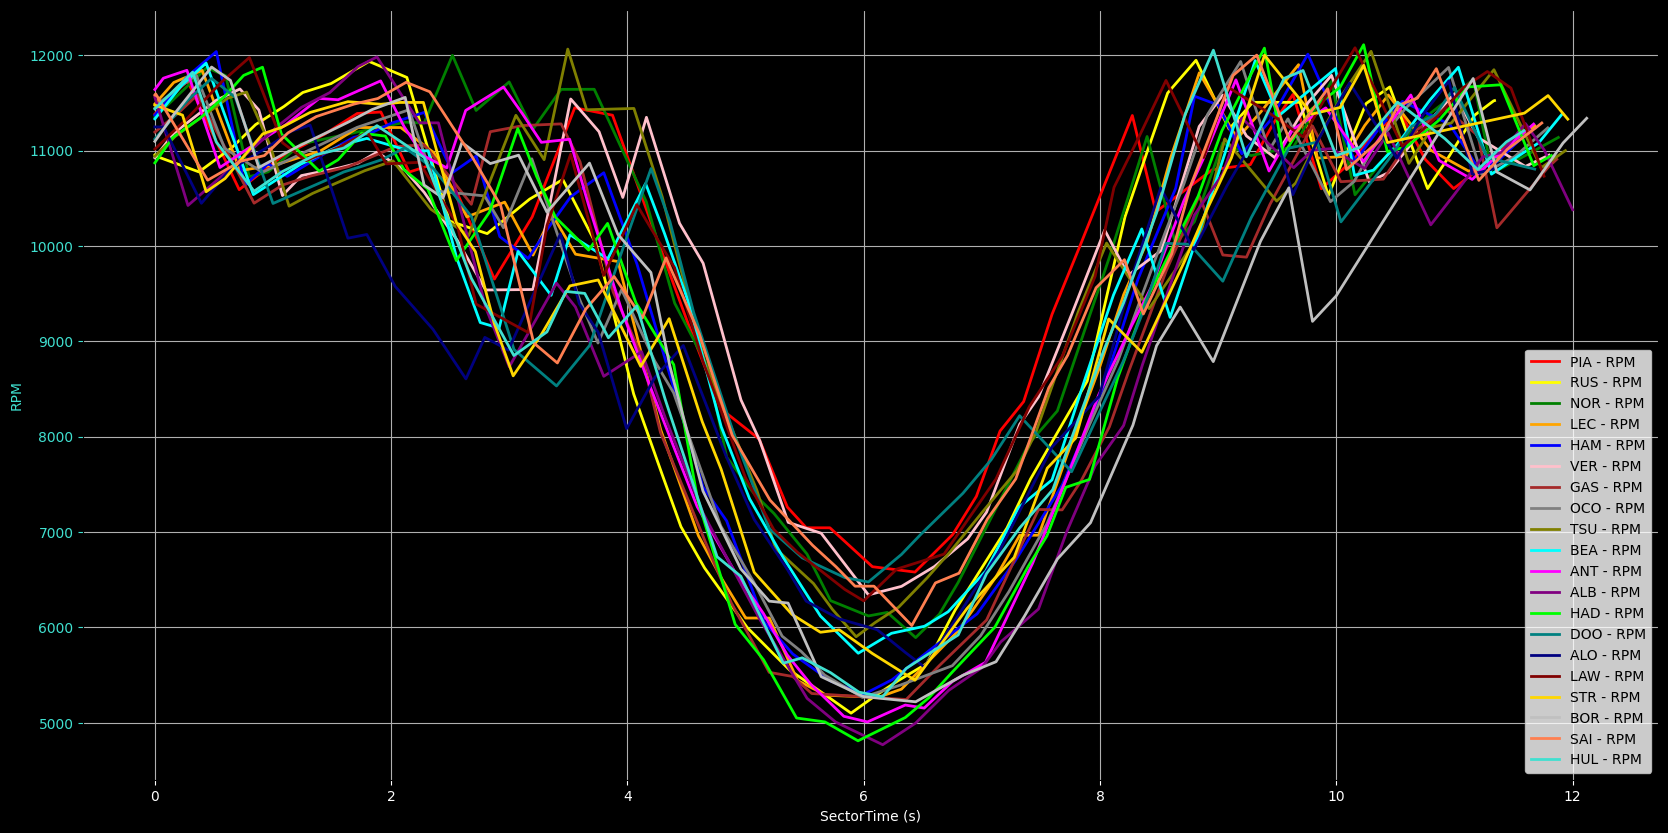

In [51]:
plots.plot_multiple_drivers_telemetry(
    dfs=[
        piastri_corner_telemetry_enriched,
        russell_corner_telemetry_enriched,
        norris_corner_telemetry_enriched,
        leclerc_corner_telemetry_enriched,
        hamilton_corner_telemetry_enriched,
        verstappen_corner_telemetry_enriched,
        gasly_corner_telemetry_enriched,
        ocon_corner_telemetry_enriched,
        tsunoda_corner_telemetry_enriched,
        bearman_corner_telemetry_enriched,
        antonelli_corner_telemetry_enriched,
        albon_corner_telemetry_enriched,
        hadjar_corner_telemetry_enriched,
        doohan_corner_telemetry_enriched,
        alonso_corner_telemetry_enriched,
        lawson_corner_telemetry_enriched,
        stroll_corner_telemetry_enriched,
        bortoleto_corner_telemetry_enriched,
        sainz_corner_telemetry_enriched,
        hulkenberg_corner_telemetry_enriched
    ],
    drivers=[
        piastri, russell, norris, leclerc, hamilton, verstappen, gasly, ocon, tsunoda, bearman, 
        antonelli, albon, hadjar, doohan, alonso, lawson, stroll, bortoleto, sainz, hulkenberg
    ],
    telemetry_cols=[rpm]
)

Grid Performance Metrics - All Drivers - The following code concatenates performance metrics for each driver into a single DataFrame.

In [47]:
all_driver_final_features = pd.concat([
    norris_final_feature_df,
    piastri_final_feature_df,
    russell_final_feature_df,
    leclerc_final_feature_df,
    hamilton_final_feature_df,
    verstappen_final_feature_df,
    gasly_final_feature_df,
    ocon_final_feature_df,
    tsunoda_final_feature_df,
    bearman_final_feature_df,
    antonelli_final_feature_df,
    albon_final_feature_df,
    hadjar_final_feature_df,
    doohan_final_feature_df,
    alonso_final_feature_df,
    lawson_final_feature_df,
    stroll_final_feature_df,
    bortoleto_final_feature_df,
    sainz_final_feature_df,
    hulkenberg_final_feature_df
], ignore_index=True)

all_driver_final_features

,Driver,Turn,RowCount,MaxSpeed,MeanSpeed,MedianSpeed,SDSpeed,MaxAccel,MeanAccel,MedianAccel,SDAccel,MaxGs,MeanGs,MedianGs,SDGs,GearShifts,ThrottleEvents,MeanThrottle,SDThrottle,BrakeEvents,InitialBrakeTime,BrakeDuration,ThrottleRampTime,SpeedMin,ExitSpeed,ExitAccelDuration,TurnDuration
0,NOR,10,98,67.500054,44.367428,45.754897,17.748605,15.873052,1.234260,3.968299,9.819282,2.023291,0.881407,0.829532,0.483419,9,2,52.670407,45.035697,1,2.482,3.720,2.719,18.055570,67.500054,5.439,12.082
1,NOR,10,92,68.041720,44.976066,47.050038,17.675422,13.888900,1.286986,5.381947,9.683591,2.023248,0.857627,0.831667,0.498864,8,2,54.125387,44.752944,1,2.521,3.519,3.123,18.888904,68.041720,5.598,12.118
2,NOR,10,90,66.506226,43.284327,43.189849,17.408523,15.625013,0.473236,4.620009,10.034389,2.301445,0.873648,0.791737,0.526786,9,2,50.855278,44.909949,1,2.601,3.280,3.203,18.333348,66.506226,5.416,11.817
3,NOR,10,96,67.777832,43.475038,44.390756,17.449550,19.097257,1.269623,4.166670,10.801510,2.478532,0.928394,0.882413,0.599280,9,2,52.897252,43.426396,1,2.524,3.360,3.663,17.777792,66.925558,5.777,12.141
4,NOR,10,96,66.842225,43.673340,44.027813,17.277407,14.880964,1.008712,3.819448,9.782563,2.655513,0.867637,0.796654,0.495042,9,2,53.384221,44.433539,1,2.881,3.439,3.064,18.333348,66.842225,5.457,12.057
5,NOR,10,98,67.222276,42.755409,42.557904,17.391280,13.194458,0.445361,2.893521,10.307803,3.363650,0.872858,0.806419,0.580660,9,2,52.622638,44.356610,1,2.505,3.560,3.304,18.333348,66.388942,5.600,12.025
6,NOR,10,86,67.500054,42.343544,41.666700,17.484763,15.046308,1.258495,4.629639,9.846778,2.124410,0.878658,0.711695,0.493701,8,2,54.534337,43.974696,1,3.200,2.960,3.405,18.333348,66.584255,5.855,12.175
7,NOR,10,90,67.222276,43.403613,45.534759,18.028656,15.046317,-0.017866,3.472224,11.023787,4.779924,0.802327,0.708137,0.782735,9,2,49.717153,44.395379,1,2.405,3.559,3.641,18.055570,65.555608,5.480,12.004
8,NOR,10,96,68.333388,43.686419,44.166702,17.761025,15.625023,1.254042,4.960324,10.382418,3.186616,0.914522,0.809300,0.540594,8,2,53.935052,43.256174,2,2.441,3.479,3.406,18.055570,67.646660,5.655,12.215
9,NOR,10,88,68.055610,45.678420,48.911151,17.147398,17.857157,1.838322,4.687505,9.868737,2.360456,0.859574,0.708137,0.548530,9,2,59.914829,42.363384,1,2.426,3.600,3.187,19.166682,66.666720,5.400,11.826


Export the all_driver_final_features dataframe as a Pickle file.

In [48]:
os.makedirs('exports/final_features', exist_ok=True)

all_driver_final_features.to_pickle('exports/final_features/2025_bahrain_sector2_grandprix.pkl')

This code loads a clustered telemetry dataframe, removes noise points, sorts by a selected feature, computes a global z-score for that feature to compare each driver to the group, and selects key columns for analysis. It can be applied to any telemetry metric.

NOTE: HDBSCAN must be executed to generate file prior to importing. It is also advised to only display columns that were used as input into the clustering model.

In [ ]:
file_path = 'exports/final_features/2025_bahrain_sector2_grandprix.pkl'
df_clustered = pd.read_pickle(file_path)

# remove noise points (cluster -1)
df_filtered = df_clustered[df_clustered['Cluster'] != -1]

# sort by selected label descending
df_clustered_sorted = df_filtered.sort_values(by=['ExitSpeed'], ascending=False)
df_clustered_sorted = df_clustered_sorted.reset_index(drop=True)

# calculate z-score for ExitSpeed
mu = df_clustered_sorted['ExitSpeed'].mean()
sigma = df_clustered_sorted['ExitSpeed'].std()
df_clustered_sorted['Z-Score'] = (df_clustered_sorted['ExitSpeed'] - mu) / sigma

# include only relevant features
features_clustered = ['Driver', 'ExitAccelDuration', 'TurnDuration', 'ExitSpeed', 'Cluster', 'Z-Score']

df_clustered_sorted[features_clustered]